### Importing required packages

In [1]:
import re
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
BATCH_SIZE = 32

### Importing data

In [4]:
!pip install gdown

In [5]:
!gdown 1ZDFmDZDOi_hrfXrKYHjt9RorHBEcT1mq

Downloading...
From: https://drive.google.com/uc?id=1ZDFmDZDOi_hrfXrKYHjt9RorHBEcT1mq
To: /kaggle/working/imdb_data.csv
100%|███████████████████████████████████████| 66.0M/66.0M [00:00<00:00, 145MB/s]


In [6]:
df = pd.read_csv(Path(os.path.join(os.getcwd(),'imdb_data.csv')))
df.head()

,Review,Rating,Sentiment
0,Imagine The Big Chill with a cast of twenty-so...,2,0
1,I'd have to say that I've seen worse Sci Fi Ch...,3,0
2,Director Fabio Barreto got a strange Academy N...,1,0
3,Pretty bad PRC cheapie which I rarely bother t...,4,0
4,This is a very intriguing short movie by David...,8,1


### Text PreProcessing

In [7]:
def text_preprocessing(text):
    # Replacing n't with not since it could be really important in sentiment analysis
    text = re.sub("n't", ' not ', text)
    # Removing URLs
    text = re.sub('(http).*\/', ' ', text)
    # Removing HTML tags
    text = re.sub('<[^>]*>', '', text)
    # Extracting emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|P|D|]|})', text)
    # Removing punctuations
    text = re.sub('[\W]+', ' ', text.lower())
    # Adding emoticons at end and converting :-) to :)
    text = text + ' ' + ' '.join(emoticons).replace('-', '')
    return text   

In [8]:
df['Review'] = df['Review'].apply(text_preprocessing)
df.head()

,Review,Rating,Sentiment
0,imagine the big chill with a cast of twenty so...,2,0
1,i d have to say that i ve seen worse sci fi ch...,3,0
2,director fabio barreto got a strange academy n...,1,0
3,pretty bad prc cheapie which i rarely bother t...,4,0
4,this is a very intriguing short movie by david...,8,1


### Splitting data into Train, Test, Valid

In [9]:
X = df['Review'].values 
y = df['Sentiment'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

### Tokenizer

In [10]:
tokenizer = DistilBertTokenizerFast.from_pretrained( 'distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [11]:
train_tokenized = tokenizer(list(X_train), truncation=True, padding=True)
valid_tokenized = tokenizer(list(X_valid), truncation=True, padding=True)
test_tokenized = tokenizer(list(X_test), truncation=True, padding=True)

### Dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, tokenized, labels):
        super().__init__()
        self.tokenized = tokenized
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        item = {key: torch.tensor(value[index]) for key, value in self.tokenized.items()}
        item['labels'] = torch.tensor(self.labels[index])
        return item

### DataLoader

In [13]:
train_data = CustomDataset(train_tokenized, y_train)
train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)

valid_data = CustomDataset(valid_tokenized, y_valid)
valid_loader = DataLoader(valid_data, BATCH_SIZE, shuffle=False)

test_data = CustomDataset(test_tokenized, y_test)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=True)

### Accuracy

In [14]:
def get_accuracy(model, data_loader):
    accuracy = 0.0
    total_loss = 0.0
    with torch.no_grad():
        model.eval()
        for _, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
            loss = outputs['loss']
            total_loss += loss.item()*len(labels)
            logits = outputs['logits']
            y_preds = torch.argmax(logits, 1)
            correct_counts = (y_preds == labels).float().sum().item()
            accuracy += correct_counts 
    accuracy = accuracy/len(data_loader.dataset)*100
    total_loss = total_loss/len(data_loader.dataset)  
    return accuracy, total_loss 

### Training

In [15]:
def training(model, model_name, optimizer, train_data_loader, valid_data_loader, num_epochs = 10):
    history = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for batch_idx, batch in enumerate(train_data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
            
            loss = outputs['loss']
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0 :
                print(f'Epoch No. {epoch+1}/{num_epochs} | Batch No. {batch_idx}/{len(train_data_loader)} | Loss = {loss:.5f}')
        training_accuracy, training_loss = get_accuracy(model, train_data_loader)
        valid_accuracy, valid_loss = get_accuracy(model, valid_data_loader)
        print(f'Training Accuracy = {training_accuracy:.2f}%, Loss = {training_loss:.4f}')
        print(f'Valid Accuracy = {valid_accuracy:.2f}%, Loss = {valid_loss:.4f}')
        history.append([training_accuracy, training_loss, valid_accuracy, valid_loss])
    return model, history    

### Post Training

In [16]:
def post_training(trained_model, test_loader, history, model_name):
    test_acc, test_loss = get_accuracy(trained_model, test_loader)
    history_np = np.array(history)
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    epochs_list = np.arange(1, len(history_np)+1)
    axes[0].plot(epochs_list, history_np[:, 0], label = "Training Accuracy", marker = '.')
    axes[0].plot(epochs_list, history_np[:, 2], label = "Validation Accuracy", marker = '.')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(epochs_list, history_np[:, 1], label = "Training Loss", marker = '.')
    axes[1].plot(epochs_list, history_np[:, 3], label = "Validation Loss", marker = '.')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    fig.suptitle(f'Training for {model_name}')
    plt.show()
    return test_loss, test_acc

### Training using DistilBert Model

In [17]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
trained_model, history = training(model, 'DistilBERT', optimizer, train_loader, valid_loader, num_epochs = 5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch No. 1/5 | Batch No. 0/1000 | Loss = 0.70962
Epoch No. 1/5 | Batch No. 100/1000 | Loss = 0.05071
Epoch No. 1/5 | Batch No. 200/1000 | Loss = 0.21385
Epoch No. 1/5 | Batch No. 300/1000 | Loss = 0.28423
Epoch No. 1/5 | Batch No. 400/1000 | Loss = 0.08616
Epoch No. 1/5 | Batch No. 500/1000 | Loss = 0.26633
Epoch No. 1/5 | Batch No. 600/1000 | Loss = 0.20825
Epoch No. 1/5 | Batch No. 700/1000 | Loss = 0.21593
Epoch No. 1/5 | Batch No. 800/1000 | Loss = 0.35883
Epoch No. 1/5 | Batch No. 900/1000 | Loss = 0.14969


 20%|██        | 1/5 [19:48<1:19:13, 1188.47s/it]

Training Accuracy = 96.92%, Loss = 0.0961
Valid Accuracy = 92.39%, Loss = 0.2014
Epoch No. 2/5 | Batch No. 0/1000 | Loss = 0.20621
Epoch No. 2/5 | Batch No. 100/1000 | Loss = 0.22757
Epoch No. 2/5 | Batch No. 200/1000 | Loss = 0.18598
Epoch No. 2/5 | Batch No. 300/1000 | Loss = 0.07687
Epoch No. 2/5 | Batch No. 400/1000 | Loss = 0.15532
Epoch No. 2/5 | Batch No. 500/1000 | Loss = 0.05357
Epoch No. 2/5 | Batch No. 600/1000 | Loss = 0.22000
Epoch No. 2/5 | Batch No. 700/1000 | Loss = 0.10740
Epoch No. 2/5 | Batch No. 800/1000 | Loss = 0.01704
Epoch No. 2/5 | Batch No. 900/1000 | Loss = 0.10614


 40%|████      | 2/5 [39:36<59:24, 1188.23s/it]  

Training Accuracy = 98.83%, Loss = 0.0465
Valid Accuracy = 92.60%, Loss = 0.1953
Epoch No. 3/5 | Batch No. 0/1000 | Loss = 0.06605
Epoch No. 3/5 | Batch No. 100/1000 | Loss = 0.03627
Epoch No. 3/5 | Batch No. 200/1000 | Loss = 0.10775
Epoch No. 3/5 | Batch No. 300/1000 | Loss = 0.01197
Epoch No. 3/5 | Batch No. 400/1000 | Loss = 0.07630
Epoch No. 3/5 | Batch No. 500/1000 | Loss = 0.11363
Epoch No. 3/5 | Batch No. 600/1000 | Loss = 0.15013
Epoch No. 3/5 | Batch No. 700/1000 | Loss = 0.06966
Epoch No. 3/5 | Batch No. 800/1000 | Loss = 0.01606
Epoch No. 3/5 | Batch No. 900/1000 | Loss = 0.00453


 60%|██████    | 3/5 [59:24<39:36, 1188.26s/it]

Training Accuracy = 99.37%, Loss = 0.0221
Valid Accuracy = 91.92%, Loss = 0.2685
Epoch No. 4/5 | Batch No. 0/1000 | Loss = 0.00835
Epoch No. 4/5 | Batch No. 100/1000 | Loss = 0.07584
Epoch No. 4/5 | Batch No. 200/1000 | Loss = 0.02164
Epoch No. 4/5 | Batch No. 300/1000 | Loss = 0.05963
Epoch No. 4/5 | Batch No. 400/1000 | Loss = 0.00246
Epoch No. 4/5 | Batch No. 500/1000 | Loss = 0.00227
Epoch No. 4/5 | Batch No. 600/1000 | Loss = 0.00953
Epoch No. 4/5 | Batch No. 700/1000 | Loss = 0.08621
Epoch No. 4/5 | Batch No. 800/1000 | Loss = 0.00205
Epoch No. 4/5 | Batch No. 900/1000 | Loss = 0.05948


 80%|████████  | 4/5 [1:19:12<19:48, 1188.16s/it]

Training Accuracy = 99.64%, Loss = 0.0153
Valid Accuracy = 92.74%, Loss = 0.2792
Epoch No. 5/5 | Batch No. 0/1000 | Loss = 0.00855
Epoch No. 5/5 | Batch No. 100/1000 | Loss = 0.05208
Epoch No. 5/5 | Batch No. 200/1000 | Loss = 0.00055
Epoch No. 5/5 | Batch No. 300/1000 | Loss = 0.00756
Epoch No. 5/5 | Batch No. 400/1000 | Loss = 0.14841
Epoch No. 5/5 | Batch No. 500/1000 | Loss = 0.01205
Epoch No. 5/5 | Batch No. 600/1000 | Loss = 0.01157
Epoch No. 5/5 | Batch No. 700/1000 | Loss = 0.00180
Epoch No. 5/5 | Batch No. 800/1000 | Loss = 0.00247
Epoch No. 5/5 | Batch No. 900/1000 | Loss = 0.00078


100%|██████████| 5/5 [1:39:00<00:00, 1188.13s/it]

Training Accuracy = 99.63%, Loss = 0.0126
Valid Accuracy = 92.39%, Loss = 0.3268


### Post Processing

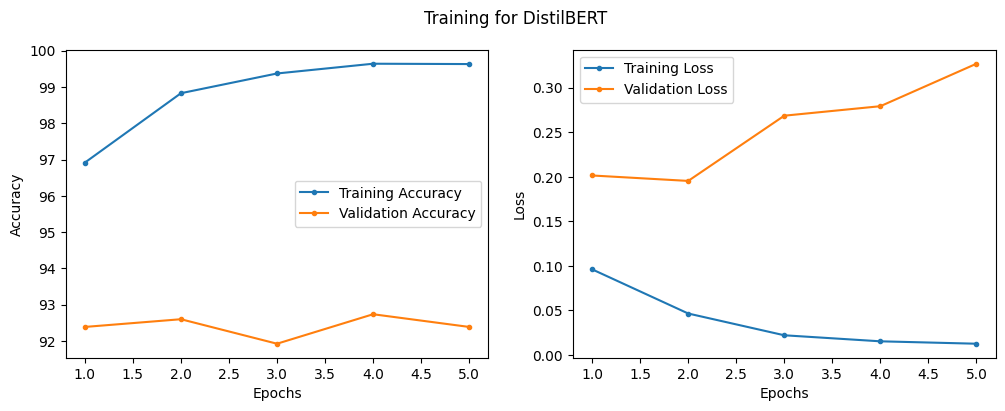

In [18]:
test_loss, test_acc = post_training(trained_model, test_loader, history, 'DistilBERT')

In [20]:
print(f'Test Accuracy = {test_acc}')

Test Accuracy = 92.06


In [34]:
torch.save(model, 'DistilBERT.pt')